In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the generators
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Define the discriminators
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = self.conv4(x)
        return x

In [ ]:
# Define the CycleGAN model
class CycleGAN(nn.Module):
    def __init__(self, g_AB, g_BA, d_A, d_B, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.g_AB = g_AB
        self.g_BA = g_BA
        self.d_A = d_A
        self.d_B = d_B
        self.lambda_cycle = lambda_cycle

    def forward(self, x_A, x_B):
        # Generate fake images from each domain
        fake_B = self.g_AB(x_A)
        fake_A = self.g_BA(x_B)
        # Reconstruct original images from the generated fake images
        reconstructed_A = self.g_BA(fake_B)
        reconstructed_B = self.g_AB(fake_A)

        # Discriminator loss on real and fake images
        d_A_loss_real = nn.functional.binary_cross_entropy_with_logits(self.d_A(x_A), torch.ones_like(self.d_A(x_A)))
        d_A_loss_fake = nn.functional.binary_cross_entropy_with_logits(self.d_A(fake_A.detach()), torch.zeros_like(self.d_A(fake_A.detach())))
        d_A_loss = (d_A_loss_real + d_A_loss_fake) / 2

        d_B_loss_real = nn.functional.binary_cross_entropy_with_logits(self.d_B(x_B), torch.ones_like(self.d_B(x_B)))
        d_B_loss_fake = nn.functional.binary_cross_entropy_with_logits(self.d_B(fake_B.detach()), torch.zeros_like(self.d_B(fake_B.detach())))
        d_B_loss = (d_B_loss_real + d_B_loss_fake) / 2

        # Generator loss for generating realistic images
        g_AB_loss = nn.functional.binary_cross_entropy_with_logits(self.d_B(fake_B), torch.ones_like(self.d_B(fake_B)))
        g_BA_loss = nn.functional.binary_cross_entropy_with_logits(self.d_A(fake_A), torch.ones_like(self.d_A(fake_A)))

        # Cycle consistency loss
        cycle_A_loss = nn.functional.l1_loss(reconstructed_A, x_A)
        cycle_B_loss = nn.functional.l1_loss(reconstructed_B, x_B)

        # Total generator loss
        g_loss = g_AB_loss + g_BA_loss + self.lambda_cycle * (cycle_A_loss + cycle_B_loss)

        return d_A_loss, d_B_loss, g_loss

In [ ]:
class SuperResolution(nn.Module):
    def __init__(self, scale_factor=2):
        super(SuperResolution, self).__init__()
        self.scale_factor = scale_factor
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 3 * (self.scale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(self.scale_factor)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = self.pixel_shuffle(x)
        return x

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class NFTDataset(Dataset):
    def __init__(self, root_dir, transform=None, downsample_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.downsample_size = downsample_size
        
        self.image_paths = []
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                    self.image_paths.append(os.path.join(subdir, file))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert('RGB')
        
        if self.downsample_size is not None:
            img = transforms.Resize(self.downsample_size)(img)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, 0  # Return 0 as label for all images 



In [ ]:
from torch.utils.data import Subset, DataLoader, RandomSampler

# Define the transforms for train and validation sets
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the full dataset and its length
full_dataset = NFTDataset('/content/drive/MyDrive/VAE/CoolCats', transform=train_transform,downsample_size=(128, 128))
dataset_length = len(full_dataset)

# Split the dataset into train and validation subsets
val_ratio = 0.2
val_size = int(val_ratio * dataset_length)
train_size = dataset_length - val_size
train_subset, val_subset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create the dataloaders for train and validation sets
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=8, sampler=RandomSampler(val_subset))

ValueError: ignored

In [ ]:
import torchvision
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0
best_val_loss = float('inf')
best_sr_val_loss = float('inf')
# Initialize the generators and discriminators
g_AB = Generator().to(device)
g_BA = Generator().to(device)
d_A = Discriminator().to(device)
d_B = Discriminator().to(device)
#sr_net = SuperResolution().to(device)

# Initialize the CycleGAN model
model = CycleGAN(g_AB, g_BA, d_A, d_B)

# Define the optimizers
g_optimizer = optim.Adam(list(g_AB.parameters()) + list(g_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
d_A_optimizer = optim.Adam(d_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_B_optimizer = optim.Adam(d_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
#sr_optimizer = optim.Adam(sr_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (x_A, _) in enumerate(train_dataloader):
        x_B, _ = next(iter(train_dataloader))

        # Transfer the data to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x_A = x_A.to(device)
        x_B = x_B.to(device)

        # Train the Super Resolution network
        #sr_optimizer.zero_grad()
        #interpolation_size = x_A.shape[2]*2
        #sr_loss = F.mse_loss(sr_net(g_AB(x_A)), F.interpolate(x_A, size=(interpolation_size, interpolation_size), mode='bicubic', align_corners=False)) + F.mse_loss(sr_net(g_BA(x_B)),F.interpolate(x_B, size=(interpolation_size, interpolation_size), mode='bicubic', align_corners=False))
        #sr_loss.backward()
        #sr_optimizer.step()

        # Train the discriminators
        d_A_optimizer.zero_grad()
        d_B_optimizer.zero_grad()
        d_A_loss, d_B_loss, _ = model(x_A, x_B)
        d_A_loss.backward()
        d_B_loss.backward()
        d_A_optimizer.step()
        d_B_optimizer.step()

        # Train the generators
        g_optimizer.zero_grad()
        _, _, g_loss = model(x_A, x_B)
        g_loss.backward()
        g_optimizer.step()

        # Print the loss every 100 batches
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Discriminator A Loss: {:.4f}, Discriminator B Loss: {:.4f}, Generator Loss: {:.4f}' # SuperResolution Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_dataloader), d_A_loss.item(), d_B_loss.item(), g_loss.item())) #,sr_loss.item()))

        # Save the generated images every 500 batches
        if (i + 1) % 500 == 0:
            #fake_B = sr_net(g_AB(x_A))
            #fake_A = sr_net(g_BA(x_B))
            fake_B = g_AB(x_A)
            fake_A = g_BA(x_B)
            torchvision.utils.save_image(fake_B, 'generated_B_{}.png'.format(i+1))
            torchvision.utils.save_image(fake_A, 'generated_A_{}.png'.format(i+1))

                # Clear the cache every 10 batches
        if (i + 1) % 10 == 0:
            torch.cuda.empty_cache()
    # Validation code here

    with torch.no_grad():
        val_loss = 0
        sr_val_loss = 0
        for val_x_A,_ in val_dataloader:
            val_x_B, _ = next(iter(val_dataloader))
            val_x_A = val_x_A.to(device)
            val_x_B = val_x_B.to(device)
            _, _, val_g_loss = model(val_x_A, val_x_B)
            val_loss += val_g_loss.item()
            sr_val_loss += F.mse_loss(sr_net(g_AB(val_x_A)), F.interpolate(val_x_A, size=(interpolation_size, interpolation_size), mode='bicubic', align_corners=False)) + F.mse_loss(sr_net(g_BA(val_x_B)),F.interpolate(val_x_B, size=(interpolation_size, interpolation_size), mode='bicubic', align_corners=False))
            
        val_loss /= len(val_dataloader)
        sr_val_loss /= len(val_dataloader)

        if val_loss < best_val_loss and sr_val_loss < best_sr_val_loss:
            best_val_loss = val_loss
            best_sr_val_loss = sr_val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch}.")
                break


In [ ]:
torch.save(model.state_dict(), "saved_model_cats.pth")
!cp /content/saved_model_cats.pth /content/drive/MyDrive/VAE

In [ ]:
# Save the model parameters
#torch.save(model.state_dict(), "saved_model.pth")
#!cp /content/saved_model.pth /content/drive/MyDrive/VAE

# Define a new instance of the CycleGAN model with the same model definitions for g_AB, g_BA, d_A, and d_B
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g_AB = Generator().to(device)
g_BA = Generator().to(device)
d_A = Discriminator().to(device)
d_B = Discriminator().to(device)
new_model = CycleGAN(g_AB, g_BA, d_A, d_B, lambda_cycle=20)

# Load the saved model parameters into the new instance of the CycleGAN model
new_model.load_state_dict(torch.load("/content/drive/MyDrive/VAE/saved_model_cats.pth"))

# Use the loaded model parameters for inference or continue training

<All keys matched successfully>

In [ ]:
# Generate new NFTs similar to those in the data
from PIL import Imageencoded = self.encoder(x)
        decoded = self.decoder(encoded)

# Load a sample image from the data
sample_image = Image.open('/content/drive/MyDrive/VAE/CoolCats/1.png').convert('RGB')
sample_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
sample_image = sample_transform(sample_image).unsqueeze(0)

# Transfer the data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_image = sample_image.to(device)

# Generate a new NFT using the generator
generator = g_AB.to(device)
#new_image = sr_net(generator(sample_image).squeeze().detach().cpu())
new_image = sr_net(generator(sample_image))

# Convert the tensor back to a PIL image and save it
new_image = transforms.functional.to_pil_image(new_image.squeeze())
new_image.save('new_nft.png')

#################
# In this part, we first load a sample image from the 
# data and apply the same transformation as before to 
# preprocess it. Then, we transfer the sample image to 
# the GPU if available and generate a new NFT using the 
# generator that we trained earlier. Finally, we convert 
# the generated tensor back to a PIL image and save it to 
# disk. The resulting image should be a new NFT that is 
# similar to those in the original data.
##################

NameError: ignored

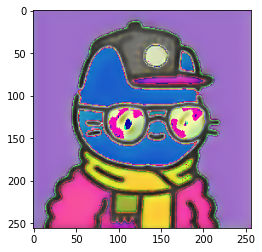

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
img = Image.open('/content/new_nft.png')

# Show the image using matplotlib
plt.imshow(img)
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def show_image_pairs(photo_path, generator_model):
    # Load the photo as a tensor
    transform = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    photo = transform(Image.open(photo_path).convert('RGB')).unsqueeze(0)

    print(photo.size)
    # Move the photo tensor to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    photo = photo.to(device)

    # Generate the output image using the generator
    with torch.no_grad():
        output = sr_net(generator_model(photo)[0])
    
    print(output.size)

    # Move the output tensor back to the CPU and convert to a NumPy array
    photo = ((photo + 1) / 2).squeeze(0).permute(1, 2, 0).cpu().numpy()
    output = ((output + 1) / 2).permute(1, 2, 0).cpu().numpy()

    # Plot the images side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(photo)
    ax[0].set_title('Input Photo')
    ax[0].axis('off')
    ax[1].imshow(output)
    ax[1].set_title('Generated Output')
    ax[1].axis('off')
    plt.show()


<built-in method size of Tensor object at 0x7f022c5ebc70>
<built-in method size of Tensor object at 0x7f022c5ebcc0>


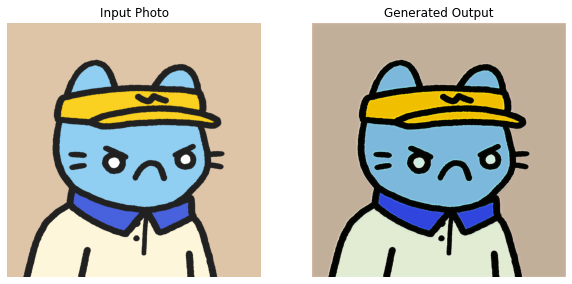

In [ ]:
# Load the CycleGAN generator model
generator_model = g_AB

# Show the before-and-after comparison of a photo
show_image_pairs('/content/drive/MyDrive/VAE/CoolCats/20.png', generator_model)


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def show_image_pairs(photo_path, generator_model):
    # Load the photo as a tensor
    transform = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    photo = transform(Image.open(photo_path).convert('RGB')).unsqueeze(0)

    print(photo.size)
    # Move the photo tensor to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    photo = photo.to(device)

    # Generate the output image using the generator
    with torch.no_grad():
        output = generator_model(photo)[0]
    
    print(output.size)

    # Move the output tensor back to the CPU and convert to a NumPy array
    photo = ((photo + 1) / 2).squeeze(0).permute(1, 2, 0).cpu().numpy()
    output = ((output + 1) / 2).permute(1, 2, 0).cpu().numpy()

    # Plot the images side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(photo)
    ax[0].set_title('Input Photo')
    ax[0].axis('off')
    ax[1].imshow(output)
    ax[1].set_title('Generated Output')
    ax[1].axis('off')
    plt.show()

<built-in method size of Tensor object at 0x7f891d4984f0>
<built-in method size of Tensor object at 0x7f891d4984f0>


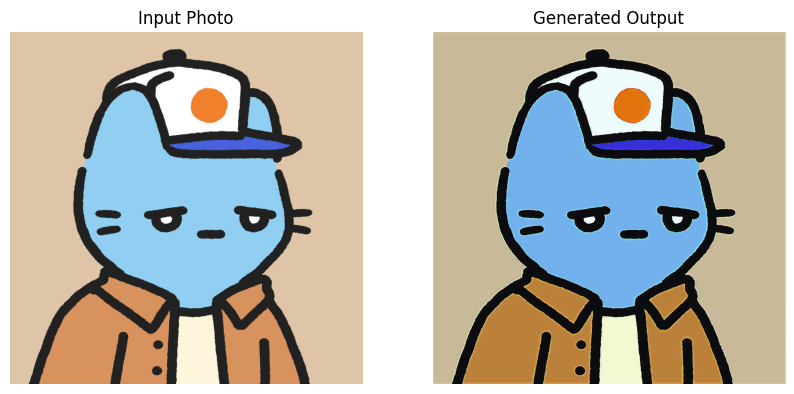

In [ ]:
# Load the CycleGAN generator model
generator_model = g_BA

# Show the before-and-after comparison of a photo
show_image_pairs('/content/drive/MyDrive/VAE/CoolCats/4.png', generator_model)
